In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re

pd.options.display.max_colwidth = 300

In [2]:
plays = pd.read_csv('/Users/Vu/Developer/Data/nfl-big-data-bowl-2023/plays.csv')
players = pd.read_csv('/Users/Vu/Developer/Data/nfl-big-data-bowl-2023/players.csv')


In [3]:
plays.head()

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,...,foulNFLId3,absoluteYardlineNumber,offenseFormation,personnelO,defendersInBox,personnelD,dropBackType,pff_playAction,pff_passCoverage,pff_passCoverageType
0,2021090900,97,(13:33) (Shotgun) T.Brady pass incomplete deep right to C.Godwin.,1,3,2,TB,DAL,TB,33,...,NaN,43.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Cover-1,Man
1,2021090900,137,(13:18) (Shotgun) D.Prescott pass deep left to A.Cooper pushed ob at DAL 30 for 28 yards (A.Winfield).,1,1,10,DAL,TB,DAL,2,...,NaN,108.0,EMPTY,"1 RB, 2 TE, 2 WR",6.0,"4 DL, 4 LB, 3 DB",TRADITIONAL,0,Cover-3,Zone
2,2021090900,187,(12:23) (Shotgun) D.Prescott pass short middle to D.Schultz to DAL 39 for 5 yards (D.White).,1,2,6,DAL,TB,DAL,34,...,NaN,76.0,SHOTGUN,"0 RB, 2 TE, 3 WR",6.0,"3 DL, 3 LB, 5 DB",TRADITIONAL,0,Cover-3,Zone
3,2021090900,282,(9:56) D.Prescott pass incomplete deep left to C.Lamb.,1,1,10,DAL,TB,TB,39,...,NaN,49.0,SINGLEBACK,"1 RB, 2 TE, 2 WR",6.0,"4 DL, 3 LB, 4 DB",TRADITIONAL,1,Cover-3,Zone
4,2021090900,349,(9:46) (Shotgun) D.Prescott pass incomplete short left to C.Lamb [L.David].,1,3,15,DAL,TB,TB,44,...,NaN,54.0,SHOTGUN,"1 RB, 1 TE, 3 WR",7.0,"3 DL, 4 LB, 4 DB",TRADITIONAL,0,Cover-3,Zone


In [4]:
plays.columns

Index(['gameId', 'playId', 'playDescription', 'quarter', 'down', 'yardsToGo',
       'possessionTeam', 'defensiveTeam', 'yardlineSide', 'yardlineNumber',
       'gameClock', 'preSnapHomeScore', 'preSnapVisitorScore', 'passResult',
       'penaltyYards', 'prePenaltyPlayResult', 'playResult', 'foulName1',
       'foulNFLId1', 'foulName2', 'foulNFLId2', 'foulName3', 'foulNFLId3',
       'absoluteYardlineNumber', 'offenseFormation', 'personnelO',
       'defendersInBox', 'personnelD', 'dropBackType', 'pff_playAction',
       'pff_passCoverage', 'pff_passCoverageType'],
      dtype='object')

In [5]:
plays.shape

(8557, 32)

- gameId: Game identifier, unique (numeric)
- playId: Play identifier, not unique across games (numeric)
- playDescription: Description of play (text)
- quarter: Game quarter (numeric)
- down: Down (numeric)
- yardsToGo: Distance needed for a first down (numeric)
- possessionTeam: Team abbr of team on offense with possession of ball (text)
- defensiveTeam: Team abbr of team on defense (text)
- yardlineSide: 3-letter team code corresponding to line-of-scrimmage (text)
- yardlineNumber: Yard line at line-of-scrimmage (numeric)
- gameClock: Time on clock of play (MM:SS)
- preSnapHomeScore: Home score prior to the play (numeric)
- preSnapVisitorScore: Visiting team score prior to the play (numeric)
- passResult: Dropback outcome of the play (C: Complete pass, I: Incomplete pass, S: Quarterback sack, IN: Intercepted pass, R: Scramble, text)
- penaltyYards: yards gained by offense by penalty (numeric)
- prePenaltyPlayResult: Net yards gained by the offense, before penalty yardage (numeric)
- playResult: Net yards gained by the offense, including penalty yardage (numeric)
- foulName[i]: Name of the i-th penalty committed during the play. i ranges between 1 and 3 (text)
- foulNFLId[i]: nflId of the player who comitted the i-th penalty during the play. i ranges between 1 and 3 (numeric)
- absoluteYardlineNumber: Distance from end zone for possession team (numeric)
- offenseFormation: Formation used by possession team (text)
- personnelO: Personnel used by offensive team (text)
- defendersInTheBox: Number of defenders in close proximity to line-of-scrimmage (numeric)
- personnelD: Personnel used by defensive team (text)
- dropbackType: Dropback categorization of quarterback (text)
- pff_playAction: indicator for whether offense executes play action fake on the play. Variable provided by PFF (binary)
- pff_passCoverage: Coverage scheme of defense. Variable provided by PFF (text)
- Possible values:
- Cover-0: A Man to Man coverage across the board with no deep defenders. This coverage is typically accompanied with a blitz
- Cover-1: When a defense plays any form of Man defense across the board with a Defensive Player as a Single High Man concept
- Cover-2: A two deep safety concept where any zone principle is applied
- 2-Man: A two deep safety concept where a man principle is applied
- Cover-3: Any 3 Deep, 4 Under concept
- Quarters: A Quarters concept on both halves of the field. In general it will be a 4 Deep, 3 Under concept where the corners are on #1, safeties on #2, and backside safety rotation dependent on formation
- Cover-6: A Quarters Concept on half the field and a 2 Deep concept on the other half
- Bracket: Recorded in the field and up to the 12 yard line in the red zone – when two offensive players have an in and out bracket by two defenders
- Goal Line: Calls where a Goal Line defense is used.
- Red Zone: Calls that are typically specific to the Red Zone and do not occur in the field often
- Prevent: Special end of half or end of game situations where a Prevent defense is utilized
- Miscellaneous: Coverage concepts that we feel do not comfortably fit into any of our coverage categories
- pff_passCoverageType: Whether defense's coverage type was man, zone or other. Variable provided by PFF (text)

Question to answer:
- Which teams committed the most penalties in 2021?
- Which teams committed the most penalties in certain situations, such as on third down or in the red zone?
- Which types of penalties did teams commit most often?
- Which players committed the most penalties?
- Are there any trends in penalty data over time?
- Are there any correlations between penalties and other factors, such as team wins or losses?
- What are the most common penalties in the NFL?
- What are the most costly penalties in the NFL?
- How do penalties affect the outcome of games?
- What can teams do to reduce penalties?
- What are the benefits of reducing penalties?

In [6]:
players.head()

,nflId,height,weight,birthDate,collegeName,officialPosition,displayName
0,25511,6-4,225,1977-08-03,Michigan,QB,Tom Brady
1,28963,6-5,240,1982-03-02,"Miami, O.",QB,Ben Roethlisberger
2,29550,6-4,328,1982-01-22,Arkansas,T,Jason Peters
3,29851,6-2,225,1983-12-02,California,QB,Aaron Rodgers
4,30078,6-2,228,1982-11-24,Harvard,QB,Ryan Fitzpatrick


## Data Cleaning

<Axes: title={'center': 'Null Values Count for Plays Dataset Columns'}>

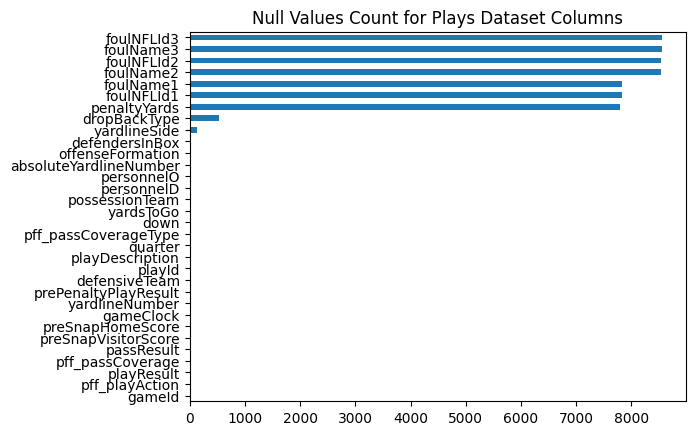

In [7]:
null_count = plays.isnull().sum()

null_count.sort_values(ascending=True).plot(kind='barh', title='Null Values Count for Plays Dataset Columns')

In [8]:
# drop columns where high count of null
plays = plays.drop(columns=['foulNFLId3', 'foulName3','foulNFLId2', 'foulName2'])

## Data Wrangling

In [9]:
plays_w_penalty = plays[['playId', 'foulName1', 'foulNFLId1', 'possessionTeam', 'defensiveTeam', 'down', 'yardsToGo', 'playDescription']]

# drop row where fouldName1 is null
plays_w_penalty = plays_w_penalty.drop(plays_w_penalty[plays_w_penalty['foulName1'].isnull()].index)

# extract team that foul was called on from play description column
plays_w_penalty['foulTeam'] = plays_w_penalty['playDescription'].str.extract(r'Penalty on (.*?)-', flags=re.IGNORECASE)

# join to players dataset to get player name that commited the foul on the play
plays_w_penalty= pd.merge(plays_w_penalty, players, left_on='foulNFLId1', right_on='nflId', how='left')

# rename displayName column to be fouldPlayerName
plays_w_penalty = plays_w_penalty.rename(columns={'displayName':'foulPlayerName'})

# clean up two cases where foul was on both team. Pick the foul that was accepted
plays_w_penalty.loc[52, 'foulTeam'] = 'HOU'
plays_w_penalty.loc[53, 'foulTeam'] = 'JAX'


## EDA

#### Which teams committed the most penalties in 2021 season?

<Axes: title={'center': 'Top 5 Team With The Most Commited Foul NFL 2021 Season'}, ylabel='foulTeam'>

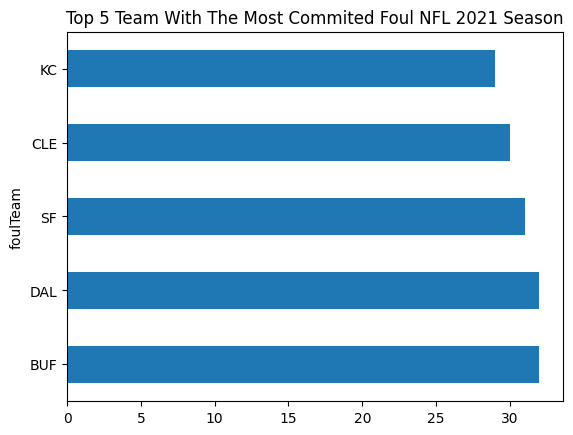

In [10]:
plays_w_penalty.groupby('foulTeam')['foulTeam'].count().sort_values(ascending=False)[:5].plot(kind='barh', title='Top 5 Team With The Most Commited Foul NFL 2021 Season')

#### Which teams committed the most penalties on third down?

<Axes: title={'center': 'Top 5 Team With The Most Commited Foul On Third Down NFL 2021 Season'}, ylabel='foulTeam'>

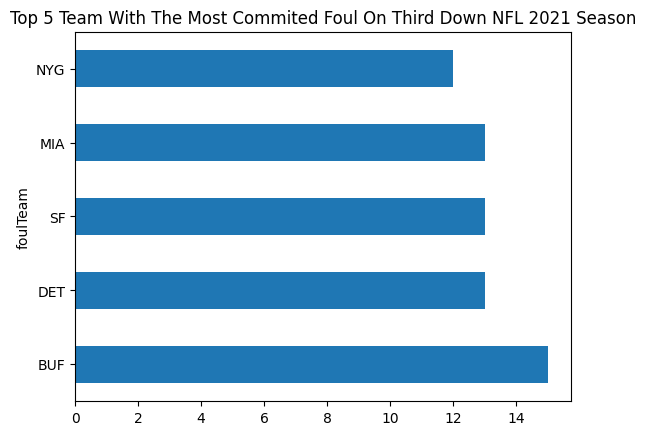

In [11]:
plays_w_penalty[plays_w_penalty['down'] == 3] \
    .groupby('foulTeam')['foulTeam'].count().sort_values(ascending=False)[:5].plot(kind='barh', title='Top 5 Team With The Most Commited Foul On Third Down NFL 2021 Season')

#### Which types of penalties did teams commit most often?

<Axes: title={'center': 'Top 5 Commited Foul Types NFL 2021 Season'}, ylabel='foulName1'>

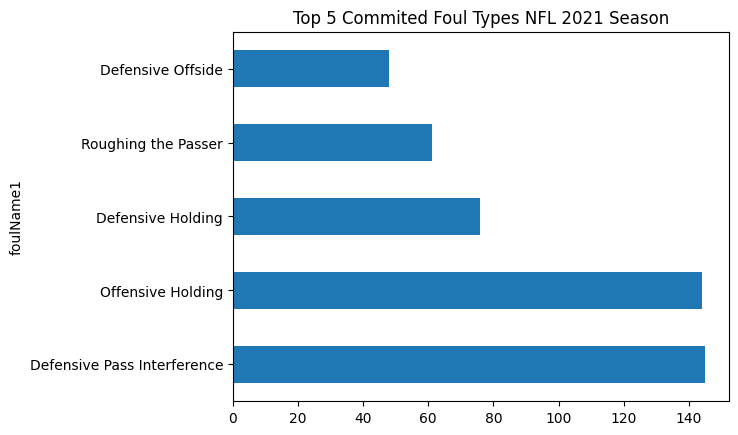

In [12]:
plays_w_penalty.groupby('foulName1')['foulName1'].count().sort_values(ascending=False)[:5] \
    .plot(kind='barh', title='Top 5 Commited Foul Types NFL 2021 Season')

#### Which players committed the most penalties?

<Axes: title={'center': 'Top 5 Players With The Most Commited Foul NFL 2021 Season'}, ylabel='foulPlayerName'>

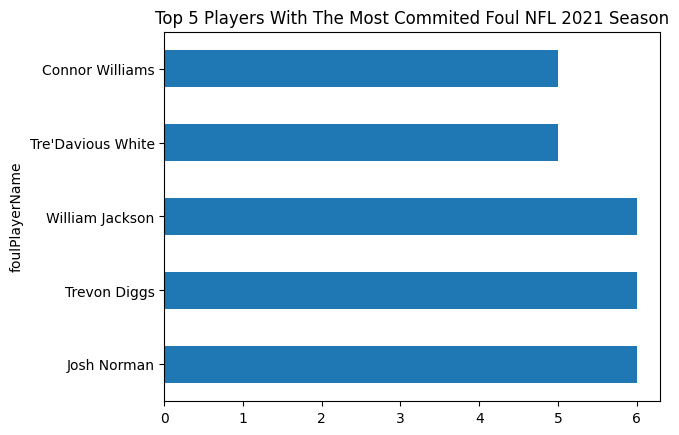

In [19]:
plays_w_penalty.groupby('foulPlayerName')['foulPlayerName'].count().sort_values(ascending=False)[:5] \
   .plot(kind='barh', title='Top 5 Players With The Most Commited Foul NFL 2021 Season')

#### Are there any trends in penalty data over time?

In [23]:
plays_w_penalty

,playId,foulName1,foulNFLId1,possessionTeam,defensiveTeam,down,yardsToGo,playDescription,foulTeam,nflId,height,weight,birthDate,collegeName,officialPosition,foulPlayerName
0,869,Illegal Use of Hands,52459.0,TB,DAL,2,7,"(:59) T.Brady pass deep middle to A.Brown to DAL 45 for 27 yards (J.Kearse). Penalty on DAL-T.Diggs, Illegal Use of Hands, declined.",DAL,52459,6-2,207,NaN,Alabama,CB,Trevon Diggs
1,1227,Taunting,40151.0,TB,DAL,3,3,"(11:29) (Shotgun) T.Brady pass short right to C.Godwin pushed ob at DAL 24 for 19 yards (J.Kearse). Penalty on TB-R.Jensen, Taunting, offsetting. Penalty on DAL-C.Watkins, Unnecessary Roughness, offsetting.",TB,40151,6-4,319,1991-05-27,Colorado State-Pueblo,C,Ryan Jensen
2,1392,Defensive Pass Interference,46132.0,DAL,TB,1,10,"(9:09) (Shotgun) D.Prescott pass incomplete short left to A.Cooper. PENALTY on TB-C.Davis, Defensive Pass Interference, 14 yards, enforced at DAL 47 - No Play.",TB,46132,6-1,206,1996-12-31,Auburn,CB,Carlton Davis
3,1506,Defensive Holding,47877.0,DAL,TB,1,10,"(8:16) (Shotgun) D.Prescott pass incomplete deep left to M.Gallup. PENALTY on TB-J.Dean, Defensive Holding, 5 yards, enforced at TB 25 - No Play.",TB,47877,6-1,206,1996-10-15,Auburn,CB,Jamel Dean
4,2129,Defensive Pass Interference,47877.0,DAL,TB,1,10,"(2:00) (Shotgun) D.Prescott pass short left to M.Gallup pushed ob at DAL 44 for 8 yards (J.Dean). PENALTY on TB-J.Dean, Defensive Pass Interference, 11 yards, enforced at DAL 36 - No Play. PENALTY on TB-J.Dean, Face Mask (15 Yards), 15 yards, enforced between downs.",TB,47877,6-1,206,1996-10-15,Auburn,CB,Jamel Dean
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
731,3796,Taunting,43880.0,NYG,KC,3,1,"(7:28) D.Jones pass short right to E.Penny to NYG 43 for 16 yards (C.Ward). PENALTY on NYG-E.Penny, Taunting, 15 yards, enforced at NYG 43.",NYG,43880,6-2,234,1993-08-17,Idaho,RB,Elijhaa Penny
732,3876,Defensive Holding,46757.0,NYG,KC,3,4,"(5:48) (Shotgun) D.Jones pass incomplete deep right to D.Slayton. PENALTY on KC-C.Ward, Defensive Holding, 5 yards, enforced at NYG 34 - No Play.",KC,46757,6-1,195,1996-05-16,Middle Tennessee,CB,Charvarius Ward
733,4016,Offensive Holding,46152.0,KC,NYG,1,10,"(4:41) (Shotgun) P.Mahomes pass incomplete short left to T.Kelce [O.Ximines]. PENALTY on KC-O.Brown, Offensive Holding, 10 yards, enforced at KC 29 - No Play.",KC,46152,6-8,345,1996-05-02,Oklahoma,T,Orlando Brown
734,4071,Defensive Offside,47878.0,KC,NYG,2,20,"(4:29) (Shotgun) P.Mahomes pass short right intended for B.Pringle INTERCEPTED by D.Holmes at KC 34. D.Holmes to KC 34 for no gain (B.Pringle). PENALTY on NYG-O.Ximines, Defensive Offside, 5 yards, enforced at KC 19 - No Play.",NYG,47878,6-4,250,1996-12-07,Old Dominion,OLB,Oshane Ximines


#### Are there any correlations between penalties and other factors, such as team wins or losses?

In [55]:
x = plays_w_penalty[['foulName1', 'down']]
x['is_foul'] = 1
x_pivot = pd.pivot_table(x, values='is_foul', index='foulName1', columns='down', aggfunc='sum', fill_value=0)
x_pivot

/var/folders/3_/fv2kdpnd0rz0zq42lhjh6v080000gp/T/ipykernel_1917/3542117951.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['is_foul'] = 1


down,0,1,2,3,4
foulName1,,,,,
Chop Block,0,0,1,0,0
Clipping,0,1,0,0,0
Defensive Holding,0,24,16,31,5
Defensive Offside,1,8,16,22,1
Defensive Pass Interference,0,45,27,68,5
Disqualification,0,1,0,1,0
Face Mask (15 Yards),0,6,14,4,0
Horse Collar Tackle,0,2,1,1,0
Illegal Blindside Block,0,3,2,0,0


In [39]:
plays_w_penalty[plays_w_penalty['down'] == 0]

,playId,foulName1,foulNFLId1,possessionTeam,defensiveTeam,down,yardsToGo,playDescription,foulTeam,nflId,height,weight,birthDate,collegeName,officialPosition,foulPlayerName
318,3903,Defensive Offside,42346.0,WAS,ATL,0,0,"TWO-POINT CONVERSION ATTEMPT. T.Heinicke pass to R.Seals-Jones is incomplete. ATTEMPT FAILS. ATL-E.Harris was injured during the play. PENALTY on ATL-D.Fowler, Defensive Offside, 4 yards, enforced at ATL 7 - No Play.",ATL,42346,6-3,255,1994-08-03,Florida,OLB,Dante Fowler
